<a href="https://colab.research.google.com/github/easy-min/2022_analysis-contest_junju/blob/main/kobert%20fine-tunning-1%EC%B0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

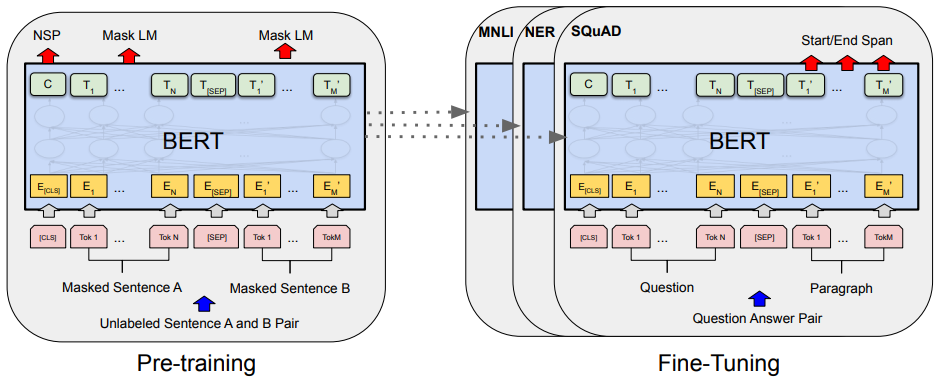

2018년 구글에서 공개한 BERT는 수많은 NLP task에서 아주 높은 성능을 보여주었으나 BERT로 한국어를 처리할 경우 영어보다 정확도가 떨어짐. KoBERT 모델은 SKTBrain에서 한국어 위키 5백만 문장과 한국어 뉴스 2천만 문장을 학습시켜 한국어 처리를 용이하게 만든 모델임.

기존에 많은 문장을 이용하여 pre-trained 되었기 때문에, 사용 목적에 따라 **output layer만 추가로 달아주는 방식**으로 fine-tuning을 진행하여 원하는 결과를 얻을 수 있음.

# [0] install & import

In [ ]:
# 패키지 설치
!pip install mxnet  # MXNet 패키지 설치
!pip install gluonnlp pandas tqdm  # GluonNLP, pandas, tqdm 패키지 설치
!pip install sentencepiece  # Sentencepiece 패키지 설치
!pip install tokenizers  # Tokenizers 패키지 설치
!pip install torch  # PyTorch 패키지 설치
!pip install pandas  # pandas 패키지 설치
!pip install transformers==4.30.0  # Transformers 패키지 설치
!pip install gluonnlp  # GluonNLP 패키지 설치

https://aws.amazon.com/ko/blogs/korea/aws-deep-learning-framework-mxnet/
- Apache Software Foundation에서 개발한 오픈 소스 딥러닝 프레임워크
- 딥 러닝 모델을 구축하고 학습시키는 것이 가능하며, 텐서 연산, 자동 미분, 신경망 구성, 학습 등을 지원
- MXNet은 효율적인 분산 학습을 지원하는데, 이는 대규모 데이터셋과 모델에 대해 더 나은 성능
- PyTorch는 간단하고 직관적인 사용성으로 인해 연구자 및 개발자들 사이에서 인기가 많지만, MXNet은 대규모 데이터와 분산 학습에 대한 효율성으로 인해 기업 환경에서 주로 사용

https://nlp.gluon.ai/

- Apache MXNet에서 제공하는 자연어 처리 라이브러리
- 다양한 자연어 처리 작업에 필요한 여러 기능과 유틸리티를 제공하여 MXNet 기반의 딥 러닝 모델을 구축하고 학습시키는 것을 지원

In [ ]:
# kobert install
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

In [ ]:
!pip install gluonnlp

In [ ]:
# PyTorch 라이브러리를 사용하여 딥러닝 모델을 구축하고 학습하기 위한 모듈들을 import
import torch
from torch import nn  # nn.Module을 상속받아 모델을 정의하기 위한 모듈
import torch.nn.functional as F  # 활성화 함수 등을 포함하는 모듈 : 활성화 함수는 인공 신경망의 각 뉴런에 대한 입력을 출력으로 변환하는 함수 : sigmoid, relu 등이 있음.
import torch.optim as optim  # 옵티마이저를 사용하기 위한 모듈 : 딥러닝 모델의 학습 과정에서 사용되는 최적화 알고리즘, 모델이 손실 함수를 최소화하는 방향으로 학습될 수 있도록 모델의 가중치를 업데이트 : 확률적 경사 하강법(SGD, Stochastic Gradient Descent), Adam, RMSprop
from torch.utils.data import Dataset, DataLoader  # 데이터셋을 불러오고 사용하기 위한 모듈
import matplotlib.pyplot as plt # 통계 확인
from sklearn.metrics import confusion_matrix # confusion_matrix 확인용 (이건 모델 돌릴 때만 사용)
from sklearn.model_selection import train_test_split
import seaborn as sns

import gluonnlp as nlp # GluonNLP은 자연어 처리를 위한 라이브러리로서, 다양한 자연어 처리 작업에 필요한 기능들을 제공함
import numpy as np # numpy는 다차원 배열을 처리하는 라이브러리로서, 행렬 연산 등을 보다 효율적으로 수행할 수 있음
import pandas as pd # pandas는 데이터를 다루는 데 사용되는 라이브러리로서, 데이터프레임 형태로 데이터를 다룰 수 있음
from tqdm import tqdm, tqdm_notebook # tqdm은 진행 상황을 시각적으로 보여주는 라이브러리로서, 데이터 처리 등에 유용하게 사용됨

from kobert_tokenizer import KoBERTTokenizer # Hugging Face의 transformers 라이브러리에서 kobert 관련 모듈을 import : kobert_tokenizer는 KoBERT의 토크나이저를 제공하는 모듈
from transformers import BertModel # transformers는 Hugging Face에서 제공하는 자연어 처리 모델과 관련된 모듈들을 제공하는 라이브러리 : BertModel은 BERT 모델을 제공하는 클래스
from transformers import AdamW # AdamW는 AdamW 옵티마이저를 제공하는 클래스
from transformers.optimization import get_cosine_schedule_with_warmup # get_cosine_schedule_with_warmup은 웜업 기간을 포함하는 코사인 스케줄러를 생성하는 함수 :학습률을 조절하기 위한 스케줄러를 생성하는 함수
# 딥러닝 모델을 학습할 때, 초기에는 학습률을 작게 설정하고 점진적으로 증가시키는 것이 도움. 웜업 기간 동안은 학습률을 선형적으로 증가시키고, 그 이후에는 코사인 함수를 사용하여 학습률을 감소

In [ ]:
# gpu setting
device = torch.device("cuda:0")
!nvidia-smi
# device = torch.device("cpu")

In [ ]:
# connecting google drive - colab
from google.colab import drive
drive.mount('/content/drive')

# [1]  데이터셋 불러오기

0 : happy (행복, 기쁨)

1 : love (사랑)

2 : angry (분노, 화)

3 : wound : 상처, 불안

4 : sad (슬픈)

## A. 대화 데이터셋

In [ ]:
# 0 : 기쁨 /  1 : 사랑 / 2 : 분노 / 3 : 불안 / 4 : 상처 / 5 : 슬픔
# 이 중에 3, 4를 3으로 통합하고 5를 4로 바꿔야 함
conv_training = pd.read_excel('/content/drive/MyDrive/emolist/dataset/filtered_corpus_data.xlsx')
conv_training.loc[conv_training['emotion'] == 4, 'emotion'] = 3 # 4를 3으로 바꾸기
conv_training.loc[conv_training['emotion'] == 5, 'emotion'] = 4 # 5를 4로 바꾸기
conv_training

NameError: name 'pd' is not defined

In [ ]:
conv_lonely = pd.read_excel('/content/drive/MyDrive/emolist/dataset/filtered_lonely.xlsx')
conv_lonely.loc[conv_lonely['emotion'] == 6, 'emotion'] = 3 # 외로움(6)을 wound(3)에 통합

NameError: name 'pd' is not defined

In [ ]:
conv_love = pd.read_excel('/content/drive/MyDrive/emolist/dataset/filtered_love.xlsx')

In [ ]:
conv_all = pd.concat([conv_training, conv_love, conv_lonely]) # 하나의 데이터셋으로 합침

In [ ]:
conv_emotion_counts = conv_all['emotion'].value_counts() # 'emotion' 값 별로 그룹화하고 각 그룹의 크기 계산
conv_emotion_counts.plot(kind='bar')
plt.xlabel('Emotion')
plt.ylabel('Number of Songs')
plt.title('Number of Songs by Emotion')
plt.show()

In [ ]:
conv_data_list = [] # extract column -> to array
for q, label in zip(conv_all['sentences'], conv_all['emotion']) :
  data = []
  data.append(q)
  data.append(str(label))

  conv_data_list.append(data)

In [ ]:
# array check
print(len(conv_data_list))
print(conv_data_list[0])
print(conv_data_list[1000])
print(conv_data_list[2000])
print(conv_data_list[3000])
print(conv_data_list[4000])
print(conv_data_list[-1])

## B. 노래 데이터셋

In [ ]:
song_happy= pd.read_csv('content/drive/MyDrive/emolist/playlist_happy.csv')
song_love = pd.read_csv('content/drive/MyDrive/emolist/playlist_love.csv')
song_angry= pd.read_csv('content/drive/MyDrive/emolist/playlist_angrysad.csv')
song_wound= pd.read_csv('content/drive/MyDrive/emolist/playlist_wound.csv')
# song_sad= pd.read_csv('content/drive/MyDrive/emolist/playlist_sad.csv')

In [ ]:
song_list = pd.concat([song_happy, song_love, song_angry, song_wound, song_sad])

In [ ]:
song_all = song_list[['Emotion', 'Lyrics']]
emotion_mapping = {'happy': 0, 'love': 1, 'angry': 2, 'wound': 3, 'sad': 4} # 'Emotion' 컬럼 값 변경
song_all['Emotion'] = song_all['Emotion'].replace(emotion_mapping)
num_missing_lyrics = (song_all['Lyrics'] == '가사를 찾을 수 없습니다.').sum()
print(f"삭제된 행 수: {num_missing_lyrics}")
song_all = song_all[song_all['Lyrics'] != '가사를 찾을 수 없습니다.'] # 'Lyrics' 컬럼이 '가사를 찾을 수 없습니다.'인 경우 삭제

In [ ]:
def split_lyrics(lyrics): # 가사를 줄바꿈(\n)x4을 기준으로 자르는 함수
    lines = lyrics.split('\n\n\n\n') # 가사를 줄바꿈을 기준으로 분리
    return lines # 줄바꿈을 기준으로 분리한 가사 리스트 반환

In [ ]:
# 각 가사를 줄바꿈을 기준으로 자르고 데이터프레임에 저장
song_all['Lyrics'] = song_all['Lyrics'].apply(split_lyrics)
song_all = song_all.explode('Lyrics').reset_index(drop=True) # explode는 리스트나 시리즈 안에 포함된 요소들을 분해하여 개별적인 행으로 만들어주는 역할

In [ ]:
song_emotion_counts = song_all['emotion'].value_counts() # 'emotion' 값 별로 그룹화하고 각 그룹의 크기 계산
song_emotion_counts.plot(kind='bar')
plt.xlabel('Emotion')
plt.ylabel('Number of Songs')
plt.title('Number of Songs by Emotion')
plt.show()

In [ ]:
song_data_list = [] # extract column -> to array
for q, label in zip(song_all['sentences'], song_all['emotion']) :
  data = []
  data.append(q)
  data.append(str(label))

  song_data_list.append(data)

In [ ]:
# array check
print(len(song_data_list))
print(song_data_list[0])
print(song_data_list[1000])
print(song_data_list[2000])
print(song_data_list[3000])
print(song_data_list[4000])
print(song_data_list[-1])

In [ ]:
combined_list = [] # 대화 데이터셋 + 노래 데이터셋 하나로 합치기
combined_list.extend(song_data_list)
combined_list.extend(conv_data_list)

In [ ]:
dataset_train, dataset_test = train_test_split(conbined_list, test_size=0.25, random_state=0) # splitting data
print(len(dataset_train))
print(len(dataset_test))

# [2] 모델 및 토큰

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, vocab=vocab, pad=pad, pair=pair)
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [ ]:
max_len = 100 # 최대 시퀀스 길이 설정
batch_size = 64 # 배치 크기 설정
warmup_ratio = 0.1 # 워밍업 비율 설정
num_epochs = 5 # 학습 에폭 수 설정
max_grad_norm = 1 # 최대 그래디언트 노름 설정
log_interval = 200 # 로그 출력 간격 설정
learning_rate = 5e-5 # 학습률 설정

In [ ]:
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1') # KoBERTTokenizer를 'skt/kobert-base-v1'로부터 가져와서 tokenizer 변수에 저장
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False) # BertModel을 'skt/kobert-base-v1'로부터 가져와서 bertmodel 변수에 저장 및 return_dict=False는 출력을 dict 형태가 아닌 일반적인 형태로 반환하도록 설정
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]') # KoBERT의 단어 사전 파일을 사용하여 BERTVocab 객체를 생성하여 vocab 변수에 저장 및 padding_token은 패딩 토큰을 지정하는 매개변수로, '[PAD]'로 설
# KoBERTTokenizer는 문장을 토큰화하고, BertModel은 KoBERT의 모델 아키텍처를 가진 모델을 로드. KoBERT의 단어 사전 파일을 사용하여 BERTVocab 객체(BERT의 어휘 사전을 관리하는 데 사용되며, 패딩 토큰을 '[PAD]'로 설정)를 생성하고, 이를 vocab 변수에 저장

In [ ]:
# preprocessing
tok = tokenizer.tokenize # KoBERTTokenizer를 'skt/kobert-base-v1'로부터 가져와서 tokenizer 변수에 저장
#tokenizer = get_tokenizer()
#tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

data_train = BERTDataset(dataset_train, 0, 1, tok, vocab, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, vocab, max_len, True, False)

train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

In [ ]:
# kobert training model
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=5, # 5개의 라벨
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
# load model
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

In [ ]:
# prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps = warmup_step, num_training_steps = t_total)

def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

# [3] training

In [ ]:
# model training
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

In [ ]:
# test
#tokenizer = get_tokenizer()
#tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
tok = tokenizer.tokenize

"""def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    #another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
    another_test = BERTDataset(dataset_another, 0, 1, tok, vocab, max_len, True, False)

    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)

    model1.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model1(token_ids, valid_length, segment_ids)

        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                test_eval.append("기쁨")
            elif np.argmax(logits) == 1:
                test_eval.append("사랑")
            elif np.argmax(logits) == 2:
                test_eval.append("분노")
            elif np.argmax(logits) == 3:
                test_eval.append("불안")
            elif np.argmax(logits) == 4:
                test_eval.append("상처")
            elif np.argmax(logits) == 5:
                test_eval.append("슬픔")
            elif np.argmax(logits) == 6:
                test_eval.append("외로움")

        print(test_eval[0])"""

def predict(predict_sentence):

  data = [predict_sentence, '0']
  dataset_another = [data]

  another_test = BERTDataset(dataset_another, 0, 1, tok, vocab, max_len, True, False)
  test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)

  model.eval()

  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
      token_ids = token_ids.long().to(device)
      segment_ids = segment_ids.long().to(device)

      valid_length= valid_length
      label = label.long().to(device)

      out = model(token_ids, valid_length, segment_ids)


      test_eval=[]
      for i in out:
          logits=i
          logits = logits.detach().cpu().numpy()

          if np.argmax(logits) == 0:
              test_eval.append("기쁨이")
          elif np.argmax(logits) == 1:
              test_eval.append("사랑이")
          elif np.argmax(logits) == 2:
              test_eval.append("분노가")
          elif np.argmax(logits) == 3:
              test_eval.append("불안이")
          elif np.argmax(logits) == 4:
              test_eval.append("상처가")
          elif np.argmax(logits) == 5:
              test_eval.append("슬픔이")
          elif np.argmax(logits) == 6:
              test_eval.append("외로움이")

      print(">> 입력하신 내용에서 " + test_eval[0] + " 느껴집니다.")

In [ ]:
# test loop: 0 to quit
end = 1
while end == 1 :
    sentence = input("write sentences: ")
    if sentence == "0" :
        break
    predict(sentence)
    print("\n")